# Error propagration with asymmetric distributions

Same as [this](https://github.com/Jayshil/csfrd/blob/main/err_p_cor_asy.ipynb) notebook, but using data from [Bouwens+21](https://arxiv.org/abs/2102.07775).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import os
import corner
import utils as utl
import posdef as pdf
from tqdm import tqdm
import scipy.integrate as inte

In [2]:
# Redshift
z_bou = np.array([2.1,2.9,3.8,4.9,5.9,6.8,7.9])

# Characteristic absolute magnitude
mst_bou = np.array([-20.28, -20.87, -20.93, -21.10, -20.93, -21.15, -20.93])
msterr_bou = np.array([0.09, 0.09, 0.08, 0.11, 0.09, 0.13, 0.28])

# Characteristic luminosity
lst_bou = np.array([])
lsterr_bou = np.array([])

for i in range(len(mst_bou)):
    mst1 = np.random.normal(mst_bou[i], msterr_bou[i], 10000)
    lst1 = utl.m_to_l_wave(mst1, 1500)
    lst_bou = np.hstack((lst_bou, np.mean(lst1)))
    lsterr_bou = np.hstack((lsterr_bou, np.std(lst1)))

# Alpha
alp_bou = np.array([-1.52, -1.61, -1.69, -1.74, -1.93, -2.06, -2.23])
alperr_bou = np.array([0.03, 0.03, 0.03, 0.06, 0.08, 0.11, 0.20])

# Normalisation constant
phi_bou = np.array([4.0, 2.1, 1.69, 0.79, 0.51, 0.19, 0.09])*0.001
phi_pos_err_bou = np.array([0.5, 0.3, 0.22, 0.16, 0.12, 0.08, 0.09])*0.001
phi_neg_err_bou = np.array([0.4, 0.3, 0.20, 0.13, 0.10, 0.06, 0.05])*0.001
phi_avg_err_bou = (phi_pos_err_bou + phi_neg_err_bou)/2

# Normalisation constant
#phi_bou = np.array([4.0, 2.1, 1.69, 0.79, 0.51, 0.19, 0.09])*0.001
#phierr_bou = np.array([0.45, 0.3, 0.21, 0.145, 0.11, 0.07, 0.07])*0.001

#log_phi_bou, log_phi_bou_err = utl.log_err(phi_bou, phierr_bou)


# Kappas
sol_lum = (con.L_sun*1e7).value
kap_uv = 2.2e-10/sol_lum
kap_ir = 4.5*10**(-44)

# Range of Luminosities (or absolute magnitudes) used
mags_bou = np.linspace(-24, -13, 1000)
lums_bou = utl.m_to_l_wave(mags_bou, 1500)

#print(np.log10(lst_bou))
#print(np.log10(lsterr_bou))
#print(np.log10(lums_bou))

In [3]:
# SFRD without error propagation
sfrd_wo_errs = np.zeros(z_bou.shape)

for i in range(len(z_bou)):
    sfrd_wo_errs[i] = utl.sfrd_wo_err(lum=lums_bou, lum1=lst_bou[i], phi1=phi_bou[i], alpha=alp_bou[i], kappa=kap_uv, limit=0.03, Auv=0.0)

In [4]:
sfrd_bou = np.zeros(z_bou.shape)
sfrd_err_bou = np.zeros(z_bou.shape)

for i in range(len(z_bou)):
    sfrd_bou[i], sfrd_err_bou[i] = utl.sfrd_w_err(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1err=phi_avg_err_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)

100%|██████████| 10000/10000 [01:32<00:00, 107.95it/s]


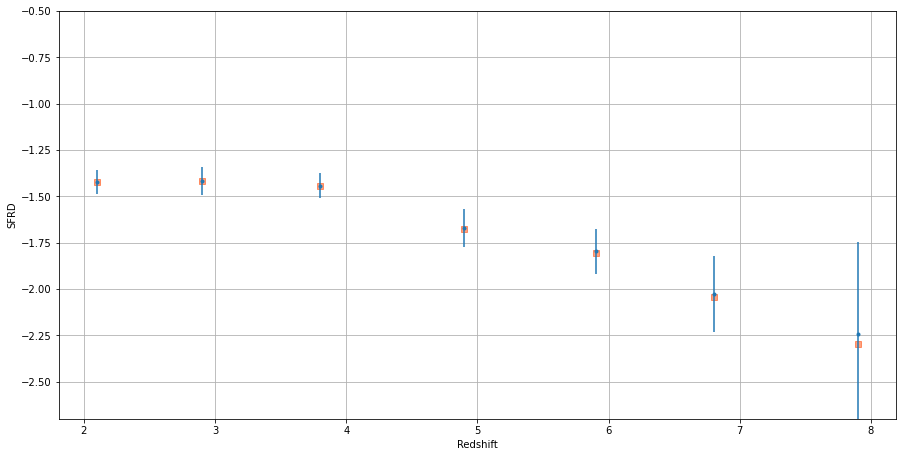

In [5]:
log_sfrd_bou, log_sfrd_bou_err =  utl.log_err(sfrd_bou, sfrd_err_bou)
log_sfrd_wo_bou = np.log10(sfrd_wo_errs)

plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou, yerr=log_sfrd_bou_err, fmt='.')
plt.scatter(z_bou, log_sfrd_wo_bou, marker='s', c='orangered', label='Without errors', alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.ylim([-2.7, -0.5])
plt.grid()

## Using asymmetric distributions

Till now, we have been using a symmetric Gaussian distribution generated from `numpy.random.normal` module to sample the distribution of various parameters. However, that is not the case always -- often, especially for the parameter $\phi_*$, the errorbars are not exactly symmetric. Hence, we want to sample asymetric distributions for those parameters. We wrote a special function to do so in `util.py` script, namely `asymmetric_gausian_distribution` -- we would implement the same function to compute the luminosity density below,

In [6]:
def lum_den22(lum, lum1, lum1err, phi1, phi1errp, phi1errn, alpha, alphaerr, limit=0.03):
    """
    Function to calculate luminosity density
    ----------------------------------------
    Parameters:
    -----------
    lum : float, numpy.ndarray
        luminosity range
    phi1 : float
        normalisation constant
    phi1errp : float
        Positive error in normalisation constant
    phi1errn : float
        Negative error in normalisation constant
    lum1 : float
        characteristic luminosity
        the 'knee' of the function
    lum1err : float
        Error in characteristic luminosity
    alpha : float
        the faint-end slope of power law
    alphaerr : float
        Error in the faint-end slope of power law
    limit : float
        lower limit of the intensity
        as a function of L*
        default is 0.03 (from Madau&Dickinson)s
    -----------
    return
    -----------
    numpy.ndarray :
        an array of luminosity density
    """
    # Values of Parameters
    log_phi1, log_phip = utl.log_err(phi1, phi1errp)
    log_phi1, log_phin = utl.log_err(phi1, phi1errn)
    log_phi2 = utl.asymmetric_gausian_distribution(log_phi1, log_phip, log_phin, 10000)
    phi2 = 10**log_phi2
    lum2 = np.random.normal(lum1, lum1err, 10000)
    alp2 = np.random.normal(alpha, alphaerr, 10000)
    # Values of luminosities
    nor_lum = np.linspace(limit*lum1, np.max(lum), 100000)
    # Integration array
    rho2 = np.array([])
    # Integration starts
    for i in tqdm(range(len(phi2))):
        if lum2[i] < 0 :#alp2[i] != alp2[i] or lum2[i] != lum2[i] or lum2[i] == 0 or phi2[i] != phi2[i]:
            continue
        else:
            nor_sc1 = utl.schechter(nor_lum, lum1=lum2[i], phi1=phi2[i], alpha=alp2[i])
            nor_sc = nor_lum*nor_sc1#/phi2[j]
            rho_nor = inte.simps(nor_sc, nor_lum)
            rho2 = np.hstack((rho2, rho_nor))
    return rho2


def sfrd_w_err(lum, lum1, lum1err, phi1, phi1errp, phi1errn, alpha, alphaerr, kappa, limit=0.03):
    """
    Function to calculate luminosity density
    ----------------------------------------
    Parameters:
    -----------
    lum : float, numpy.ndarray
        luminosity range
    phi1 : float
        normalisation constant
    phi1errp : float
        Positive error in normalisation constant
    phi1errn : float
        Negative error in normalisation constant
    lum1 : float
        characteristic luminosity
        the 'knee' of the function
    lum1err : float
        Error in characteristic luminosity
    alpha : float
        the faint-end slope of power law
    alphaerr : float
        Error in the faint-end slope of power law
    kappa : float
        conversion factor b/w luminosity density and
        star formation rate
    limit : float
        lower limit of the intensity
        as a function of L*
        default is 0.03 (from Madau&Dickinson)
    -----------
    return
    -----------
    float
        mean star formation rate
    float
        error in star formation rate
    """
    lum_den2 = lum_den22(lum, lum1, lum1err, phi1, phi1errp, phi1errn, alpha, alphaerr, limit)
    kpp1 = kappa
    sfr2 = kpp1*lum_den2
    sfr_m, sfrp, sfrn = utl.get_quantiles(sfr2)
    return sfr_m, sfrp-sfr_m, sfr_m-sfrn

In [7]:
sfrd_bou_asy = np.zeros(z_bou.shape)
sfrd_perr_bou_asy = np.zeros(z_bou.shape)
sfrd_nerr_bou_asy = np.zeros(z_bou.shape)

for i in range(len(z_bou)):
    sfrd_bou_asy[i], sfrd_perr_bou_asy[i], sfrd_nerr_bou_asy[i] = sfrd_w_err(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1errp=phi_pos_err_bou[i], phi1errn=phi_neg_err_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)

100%|██████████| 10000/10000 [02:05<00:00, 79.84it/s]


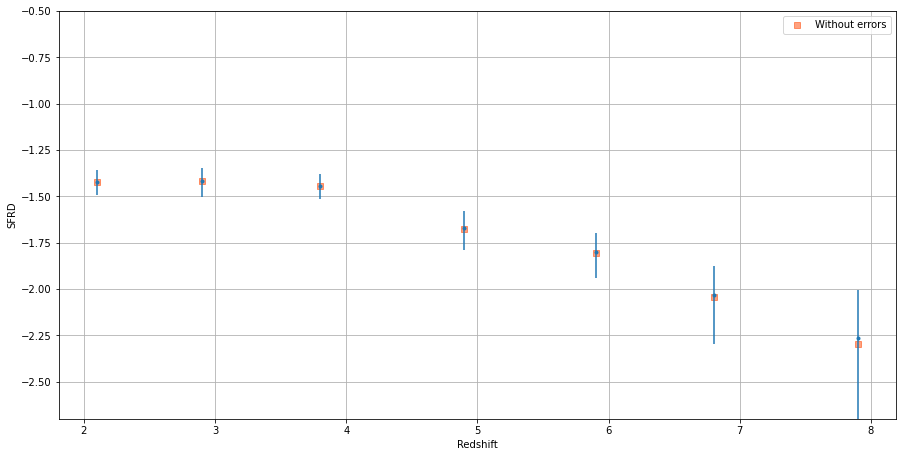

In [8]:
log_sfrd_bou_asy, log_sfrd_bou_perr_asy =  utl.log_err(sfrd_bou_asy, sfrd_perr_bou_asy)
log_sfrd_bou_asy, log_sfrd_bou_nerr_asy =  utl.log_err(sfrd_bou_asy, sfrd_nerr_bou_asy)

plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou_asy, yerr=[log_sfrd_bou_perr_asy, log_sfrd_bou_nerr_asy], fmt='.')
plt.scatter(z_bou, log_sfrd_wo_bou, marker='s', c='orangered', label='Without errors', alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.legend(loc='best')
plt.ylim([-2.7, -0.5])
plt.grid()

In [9]:
for i in range(len(sfrd_bou)):
    print('--------------------------------------------------------------------------------')
    print('At redshift {:.1f}'.format(z_bou[i]))
    print('--------------------------------------------------------------------------------')
    print('Without Error Propagation:')
    print('--------------------------')
    print('Value of SFRD is: {:.2e}'.format(sfrd_wo_errs[i]))
    print('Value of log(SFRD) is: {:.2e}'.format(log_sfrd_wo_bou[i]))
    print('--------------------------------------------------------------')
    print('With Error Propagation (wo taking into account of correlations)')
    print('--------------------------------------------------------------')
    print('Value of SFRD is: {:.2e} +/- {:.2e}'.format(sfrd_bou[i], sfrd_err_bou[i]))
    print('Value of log(SFRD) is: {:.2e} +/- {:.2e}'.format(log_sfrd_bou[i], log_sfrd_bou_err[i]))
    print('--------------------------------------------------------------')
    print('With Error propagation and with asymmetric distribution')
    print('--------------------------------------------------------------')
    print('Value of SFRD is: {:.2e} +/- {:.2e}'.format(sfrd_bou_asy[i], sfrd_perr_bou_asy[i]))
    print('Value of log(SFRD) is: {:.2e} +/- {:.2e}'.format(log_sfrd_bou_asy[i], log_sfrd_bou_perr_asy[i]))
    print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
At redshift 2.1
--------------------------------------------------------------------------------
Without Error Propagation:
--------------------------
Value of SFRD is: 3.79e-02
Value of log(SFRD) is: -1.42e+00
--------------------------------------------------------------
With Error Propagation (wo taking into account of correlations)
--------------------------------------------------------------
Value of SFRD is: 3.80e-02 +/- 5.66e-03
Value of log(SFRD) is: -1.42e+00 +/- 6.48e-02
--------------------------------------------------------------
With Error propagation and with asymmetric distribution
--------------------------------------------------------------
Value of SFRD is: 3.80e-02 +/- 6.38e-03
Value of log(SFRD) is: -1.42e+00 +/- 7.29e-02
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
At